## Import Necessary Libraries

In [ ]:
#import os
#os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

print(f"Keras version: {keras.__version__}")
print(f"Using backend: {keras.backend.backend()}")

Keras version: 3.12.0
Using backend: tensorflow


In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras
import torch 
from torch.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

print(f"Keras version: {keras.__version__}")
print(f"Using backend: {keras.backend.backend()}")

## Import Data

In [ ]:
#define data paths
TRAINING_DIR = "split_data/training/"
VALIDATION_DIR = "split_data/validation/"
TEST_DIR = "split_data/test/"

## Create Data Generators with Augmentation

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
  #create the ImageDataGenerator class for the training set
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
  
  #only apply the rescale transformation to the validation and test sets
  val_test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='sparse',
                                                      target_size=(224, 224))
  validation_generator = val_test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='sparse',
                                                              target_size=(224, 224))
  test_generator = val_test_datagen.flow_from_directory(directory=TEST_DIR,
                                                        batch_size=32,
                                                        class_mode='sparse',
                                                        target_size=(224, 224))
  return train_generator, validation_generator, test_generator


In [ ]:
#test the generators
train_generator, validation_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR)

Found 544 images belonging to 3 classes.
Found 154 images belonging to 3 classes.
Found 154 images belonging to 3 classes.
Found 82 images belonging to 3 classes.
Found 82 images belonging to 3 classes.


## Focal Loss 
Best for imbalanced image dataset, especially for malignant vs. benign in which it is highly similar

In [ ]:
def focal_loss(gamma=2.0, alpha=0.25):
    epsilon = 1e-7  # replaces keras.epsilon()

    def focal_loss_fixed(y_true, y_pred):
        # Convert sparse labels to one-hot encoding
        y_true = tensorflow.cast(y_true, tensorflow.int32)
        y_true = tensorflow.one_hot(y_true, depth=tensorflow.shape(y_pred)[-1])
        y_true = tensorflow.cast(y_true, y_pred.dtype)
        
        # Clip predictions to avoid log(0)
        y_pred = tensorflow.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # pt = y_pred if y_true == 1 else (1 - y_pred)
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        
        # at = alpha for positive class, (1 - alpha) for negative class
        at = y_true * alpha + (1 - y_true) * (1 - alpha)
        
        # Focal Loss formula
        loss = -at * tensorflow.pow((1 - pt), gamma) * tensorflow.math.log(pt)

        return tensorflow.reduce_mean(loss)
    
    return focal_loss_fixed

## Baseline CNN model

In [ ]:
#define function to create cnn model
def create_model():

  model = keras.models.Sequential([

    keras.layers.Conv2D(32, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(256, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 
    
    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation="relu"), 
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(3, activation="softmax")

  ])

  model.compile(optimizer='adam', loss=focal_loss(gamma=2.0, alpha=0.25), metrics=['accuracy'])

  return model

In [ ]:
#create untrained model
cnn_model = create_model()

In [ ]:
#model summary
cnn_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,718,083 (98.11 MB)

 Trainable params: 25,718,083 (98.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#set up early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=10,
                           restore_best_weights=True)
]

In [ ]:
#train the model
history = cnn_model.fit(train_generator, validation_data=validation_generator, epochs=100, callbacks = callbacks)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 673ms/step - accuracy: 0.4210 - loss: 1.1457 - val_accuracy: 0.5584 - val_loss: 0.0575
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 673ms/step - accuracy: 0.4210 - loss: 1.1457 - val_accuracy: 0.5584 - val_loss: 0.0575
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 566ms/step - accuracy: 0.5625 - loss: 0.0587 - val_accuracy: 0.5584 - val_loss: 0.0575
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 566ms/step - accuracy: 0.5625 - loss: 0.0587 - val_accuracy: 0.5584 - val_loss: 0.0575
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 574ms/step - accuracy: 0.5625 - loss: 0.0577 - val_accuracy: 0.5584 - val_loss: 0.0571
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 574ms/step - accuracy: 0.5625 - loss: 0.0577 - val_accuracy: 0.5584 - val_loss: 0.0571
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 572ms/step - accuracy: 0.5625 - loss: 0.0574 - val_accuracy: 0.5649 - val_loss: 0.0549
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 572ms/step - accuracy: 0.5625 - loss: 0.0574 - 

## Display Training Progress

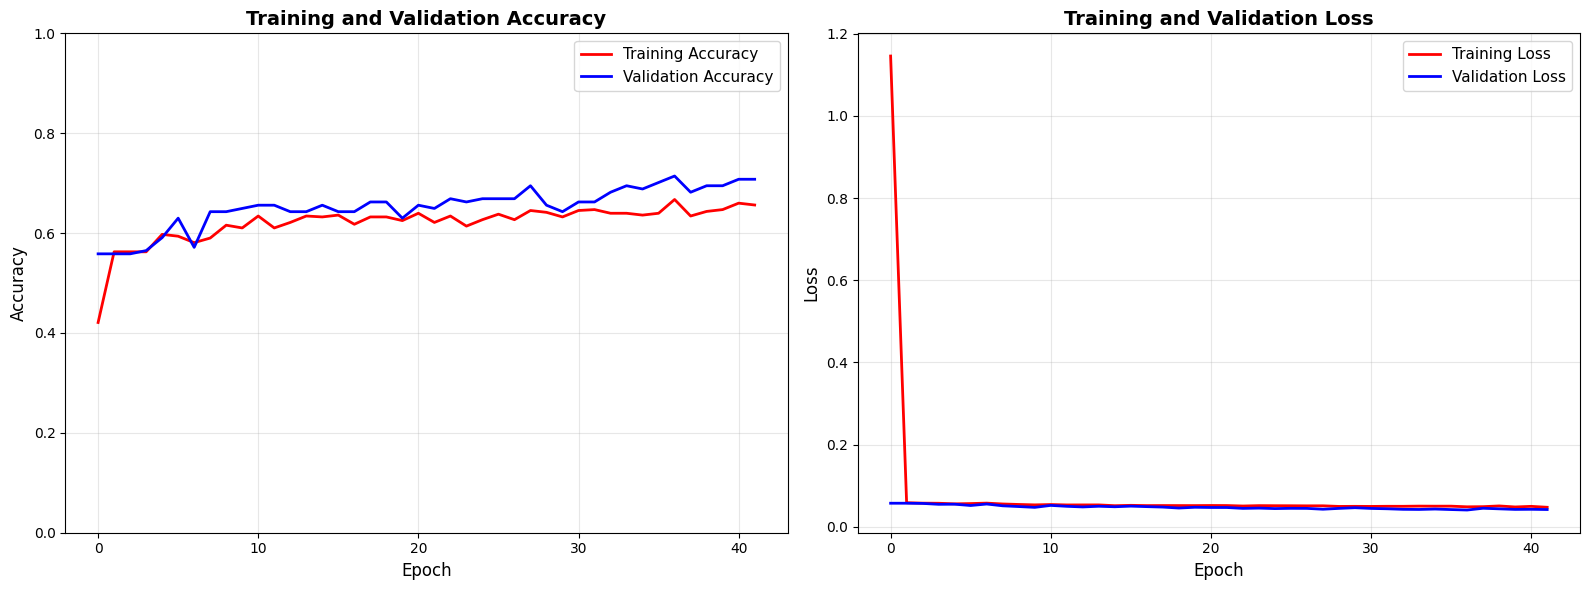


  Training Summary
  Best Training Accuracy:   0.6673 (epoch 37)
  Best Validation Accuracy: 0.7143 (epoch 37)
  Final Training Accuracy:  0.6562
  Final Validation Accuracy:0.7078
  Accuracy Gap (final):     0.0515


In [ ]:
#training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#get number of epochs actually executed with early stopping
epochs_range = range(len(acc))

#create plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#plot accuracy
ax1.plot(epochs_range, acc, 'r-', linewidth=2, label="Training Accuracy")
ax1.plot(epochs_range, val_acc, 'b-', linewidth=2, label="Validation Accuracy")
ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

#plot loss
ax2.plot(epochs_range, loss, 'r-', linewidth=2, label="Training Loss")
ax2.plot(epochs_range, val_loss, 'b-', linewidth=2, label="Validation Loss")
ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#print summary stats
print(f"\n{'='*60}")
print(f"  Training Summary")
print(f"{'='*60}")
print(f"  Best Training Accuracy:   {max(acc):.4f} (epoch {acc.index(max(acc))+1})")
print(f"  Best Validation Accuracy: {max(val_acc):.4f} (epoch {val_acc.index(max(val_acc))+1})")
print(f"  Final Training Accuracy:  {acc[-1]:.4f}")
print(f"  Final Validation Accuracy:{val_acc[-1]:.4f}")
print(f"  Accuracy Gap (final):     {abs(acc[-1] - val_acc[-1]):.4f}")
print(f"{'='*60}")

## Evaluate model

In [ ]:
#get test accuracy and loss
preds = cnn_model.evaluate(test_generator)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.7439 - loss: 0.0481
Loss = 0.04810236766934395
Test Accuracy = 0.7439024448394775
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.7439 - loss: 0.0481
Loss = 0.04810236766934395
Test Accuracy = 0.7439024448394775


In [87]:
#evaluate on val set
validation_generator.shuffle = False
y_true = validation_generator.classes
y_pred_probs = cnn_model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Val Classification Report:")
print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step
Val Classification Report:
              precision    recall  f1-score   support

      benign       0.59      0.83      0.69        86
   malignant       0.26      0.19      0.22        42
      normal       0.67      0.08      0.14        26

    accuracy                           0.53       154
   macro avg       0.51      0.36      0.35       154
weighted avg       0.51      0.53      0.47       154

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step
Val Classification Report:
              precision    recall  f1-score   support

      benign       0.59      0.83      0.69        86
   malignant       0.26      0.19      0.22        42
      normal       0.67      0.08      0.14        26

    accuracy                           0.53       154
   macro avg       0.51      0.36      0.35       154
weighted avg       0.51      0.53      0.47       154



In [88]:
#evaluate on test set
test_generator.shuffle = False
y_true = test_generator.classes
y_pred_probs = cnn_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Test Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
Test Classification Report:
              precision    recall  f1-score   support

      benign       0.50      0.64      0.56        45
   malignant       0.27      0.27      0.27        22
      normal       0.00      0.00      0.00        15

    accuracy                           0.43        82
   macro avg       0.26      0.31      0.28        82
weighted avg       0.35      0.43      0.38        82

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
Test Classification Report:
              precision    recall  f1-score   support

      benign       0.50      0.64      0.56        45
   malignant       0.27      0.27      0.27        22
      normal       0.00      0.00      0.00        15

    accuracy                           0.43        82
   macro avg       0.26      0.31      0.28        82
weighted avg       0.35      0.43      0.38        82



In [89]:
#evaluate on train set
train_generator.shuffle = False
y_true = train_generator.classes
y_pred_probs = cnn_model.predict(train_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Train Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 342ms/step
Train Classification Report:
              precision    recall  f1-score   support

      benign       0.58      0.70      0.64       306
   malignant       0.22      0.26      0.24       146
      normal       0.00      0.00      0.00        92

    accuracy                           0.47       544
   macro avg       0.27      0.32      0.29       544
weighted avg       0.39      0.47      0.42       544

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 342ms/step
Train Classification Report:
              precision    recall  f1-score   support

      benign       0.58      0.70      0.64       306
   malignant       0.22      0.26      0.24       146
      normal       0.00      0.00      0.00        92

    accuracy                           0.47       544
   macro avg       0.27      0.32      0.29       544
weighted avg       0.39      0.47      0.42       544

